In [1]:
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.ops import shared_paths

import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns


%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
path = r"E:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\data"
map_path = r"E:\tencent files\chrome Download\QGIS 3.12\中国基础数据\中国行政区.shp"

trans_2010 = r"coal_transport2010"
trans_2014 = r"coal_transport2014"

geo_data_file = r"Distance_matrix"

transport_matrix_2010 = r"coal_trasport2010.xlsx"
transport_matrix_2014 = r"coal_trasport2014.xlsx"

power_plants_orginal_2010 = r"coal_elec_gen2010_SD.xlsx"
power_plants_orginal_2014 = r"coal_elec_gen2014_SD.xlsx"
mines = "node_mine_pair.xlsx"
power_plants = "node_power_pair.xlsx"
file = r"Results.xlsx"

power_plant_points_2010 = os.path.join(path, trans_2010, power_plants_orginal_2010)
transport_route_path_2010 = os.path.join(path, trans_2010, geo_data_file)
transport_quantity_path_2010 = os.path.join(path, trans_2010, transport_matrix_2010)

power_plant_points_2014 = os.path.join(path, trans_2014, power_plants_orginal_2014)
transport_route_path_2014 = os.path.join(path, trans_2014, geo_data_file)
transport_quantity_path_2014 = os.path.join(path, trans_2014, transport_matrix_2014)

<IPython.core.display.Javascript object>

In [3]:
os.chdir(os.path.join(path, trans_2010))

with open("transport_route_gdf.pickle", "rb") as file:
    transport_gdf_2010 = pickle.load(file)

os.chdir(os.path.join(path, trans_2014))

with open("transport_route_gdf.pickle", "rb") as file:
    transport_gdf_2014 = pickle.load(file)

<IPython.core.display.Javascript object>

In [4]:
def CHN_map(map_path):
    CHN_adm = gpd.read_file(map_path)
    CHN_adm.to_crs("epsg:4326")
    return CHN_adm

<IPython.core.display.Javascript object>

In [363]:
def power_plant_data(transport_gdf1):
    pp2010_ls = gpd.GeoDataFrame(
        [
            Point(list(transport_gdf1.geometry.iloc[i].coords)[-1])
            for i in range(len(transport_gdf1.geometry))
        ],
        columns=["geometry"],
    ).set_index(transport_gdf1.index)

    power_plant_2010 = gpd.GeoDataFrame(  # 2010年电厂位置
        pd.concat([pp2010_ls, transport_gdf1[0]], axis=1)
    )
    power_plant_2010.columns = ["geometry", "coal_quantity"]
    power_plant_2010["Dissolve"] = power_plant_2010["geometry"].apply(lambda x: str(x))
    power_plant_2010 = power_plant_2010.dissolve(by="Dissolve", aggfunc="sum")

    return power_plant_2010

<IPython.core.display.Javascript object>

In [374]:
def power_plant(transport_gdf1=transport_gdf_2010, transport_gdf2=transport_gdf_2014):

    power_plant_2010 = power_plant_data(transport_gdf1)
    power_plant_2014 = power_plant_data(transport_gdf2)
    # 2010-2014年持续存在电厂，二者位置相同
    persist_ls = []
    persist_quantity_ls = []
    for point, coal_quantity in zip(
        power_plant_2010.geometry, power_plant_2010["coal_quantity"]
    ):
        if any(p.equals(point) for p in power_plant_2014.geometry):
            persist_ls.append(point)
            persist_quantity_ls.append(coal_quantity)

    persist_df = pd.concat(
        [pd.Series(persist_ls), pd.Series(persist_quantity_ls)], axis=1
    )
    persist_gdf = gpd.GeoDataFrame(persist_df)
    persist_gdf.columns = ["geometry", "coal_quantity"]

    retire_ls = []  # 2010年退役的电厂，位置与2014年不同
    retire_quantity_ls = []
    for point, quantity in zip(
        power_plant_2010.geometry, power_plant_2010["coal_quantity"]
    ):
        if point not in power_plant_2014.geometry:
            retire_ls.append(point)
            retire_quantity_ls.append(quantity)

    # 因为我们通过路径最后一段来确定电厂，可能存在因为路径重复导致的电厂位置重复，这里去除退役电厂的重复位置
    retire_screen_ls = []
    retire_screen_quantity_ls = []
    for point, quantity in zip(retire_ls, retire_quantity_ls):
        if not any(p.distance(point) < 0.01 for p in retire_screen_ls):
            retire_screen_ls.append(point)
            retire_screen_quantity_ls.append(quantity)

    retire_df = pd.concat(
        [pd.Series(retire_screen_ls), pd.Series(retire_screen_quantity_ls)], axis=1
    )
    retire_gdf = gpd.GeoDataFrame(retire_df)
    retire_gdf.columns = ["geometry", "coal_quantity"]

    # 同样的，我们去除新建电厂中的重复位置
    newly_built_ls = []
    newly_built_quantity_ls = []
    for point, quantity in zip(
        power_plant_2014.geometry, power_plant_2014["coal_quantity"]
    ):
        if point not in power_plant_2010.geometry:
            newly_built_ls.append(point)
            newly_built_quantity_ls.append(quantity)

    newly_built_screen_ls = []
    newly_built_screen_quantity_ls = []

    for point, quantity in zip(newly_built_ls, newly_built_quantity_ls):
        if not any(p.distance(point) < 0.01 for p in newly_built_screen_ls):
            newly_built_screen_ls.append(point)
            newly_built_screen_quantity_ls.append(quantity)
    newly_built_df = pd.concat(
        [pd.Series(newly_built_screen_ls), pd.Series(newly_built_screen_quantity_ls)],
        axis=1,
    )

    newly_built_gdf = gpd.GeoDataFrame(newly_built_df)
    newly_built_gdf.columns = ["geometry", "coal_quantity"]

    return persist_gdf, retire_gdf, newly_built_gdf

<IPython.core.display.Javascript object>

In [375]:
persist_gdf, retire_gdf, newly_built_gdf = power_plant()

newly_built_gdf.head()

,geometry,coal_quantity
0,POINT (115.12860 35.35789),336852.004
1,POINT (115.44940 36.49024),92344.000
2,POINT (115.45291 35.23413),2849525.030
3,POINT (115.48755 35.23941),3789959.030
4,POINT (115.49443 35.19813),30540.000


<IPython.core.display.Javascript object>

In [376]:
len(persist_gdf), len(retire_gdf), len(newly_built_gdf),

(32, 226, 62)

<IPython.core.display.Javascript object>

In [386]:
def map_draw(transport_gdf, power_plant_path, color_dict, map_path=map_path):

    fig, ax = plt.subplots(figsize=(16, 16), edgecolor="black")
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(3)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.get_yticklabels(), visible=False)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.xlim((111, 124))
    plt.ylim((33, 41))

    CHN_adm = CHN_map(map_path)
    CHN_adm.plot(
        ax=ax, color=(0.95, 0.95, 0.95), edgecolor=(0.90, 0.92, 0.91), linewidth=2.5
    )

    max_ = transport_gdf.iloc[:, -1].max()
    min_ = transport_gdf.iloc[:, -1].min()
    mean_ = transport_gdf.iloc[:, -1].mean()

    transport = transport_gdf.plot(
        column=np.log10(transport_gdf.iloc[:, -1]),
        ax=ax,
        cmap="GnBu",
        linewidth=50 * (transport_gdf.iloc[:, -1] - min_ + 50000) / (max_ - min_),
        legend=False,
        vmin=2,
        vmax=7,
    )

    persist_gdf, retire_gdf, newly_built_gdf = power_plant()
    persist_gdf.plot(  # 画持续存在的电厂
        ax=ax,
        facecolors="none",
        edgecolors=color_dict["persist"],
        marker="o",
        linewidth=4,
        markersize=persist_gdf["coal_quantity"] / 3000,
        alpha=0.7,
    )
    if transport_gdf is transport_gdf_2010:  # 画退役电厂
        retire_gdf.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["retire"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=retire_gdf["coal_quantity"] / 3000,
        )
    else:  # 画新建电厂
        newly_built_gdf.geometry.plot(
            ax=ax,
            facecolors="None",
            edgecolors=color_dict["newly_built"],
            marker="o",
            linewidth=4,
            linestyle="solid",
            markersize=newly_built_gdf["coal_quantity"] / 3000,
        )
    mine = gpd.GeoDataFrame(
        [
            Point(list(transport_gdf.geometry.iloc[i].coords)[0])
            for i in range(len(transport_gdf.geometry))
        ],
        columns=["geometry"],
    )
    mine_screened = []
    for point in mine.geometry:
        if not any(p.distance(point) <= 0.2 for p in mine_screened):
            mine_screened.append(point)

    mine_screened_gdf = gpd.GeoDataFrame(mine_screened, columns=["geometry"])
    mine_screened_gdf.plot(
        ax=ax,
        facecolors="none",
        edgecolors=color_dict["mine"],
        marker="^",
        linewidth=4,
        markersize=200,
        alpha=1,
    )

    return fig

<IPython.core.display.Javascript object>

In [349]:
def colorbar(transport_gdf):
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = mpl.colors.Normalize(vmin=np.power(10,2), vmax=np.power(10,7))

    
    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap="GnBu"),
        cax=ax,
        orientation="horizontal",
    )
    cbar.ax.tick_params(labelsize=12)


<IPython.core.display.Javascript object>

In [350]:
color_dict = {
    "persist": (0.96, 0.50, 0.09),
    "retire": (0.89, 0.10, 0.11),
    "newly_built": (0.19, 0.64, 0.33),
    "mine": (0.39, 0.39, 0.39),
}

<IPython.core.display.Javascript object>

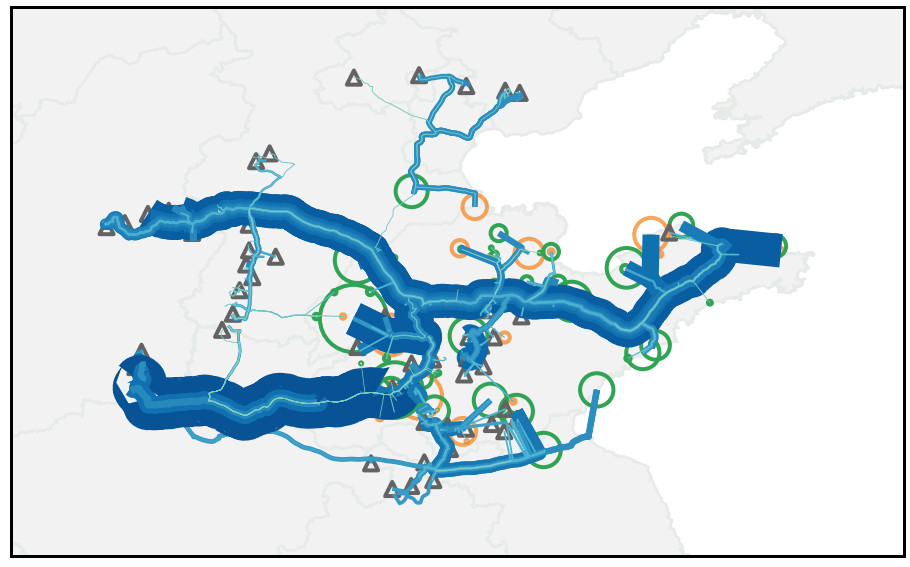

<IPython.core.display.Javascript object>

In [389]:
map_draw(transport_gdf_2014,power_plant_points_2014,color_dict=color_dict,)

plt.savefig(
    r"E:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport2014.png",
    dpi=600,
    bbox_inches="tight",
)


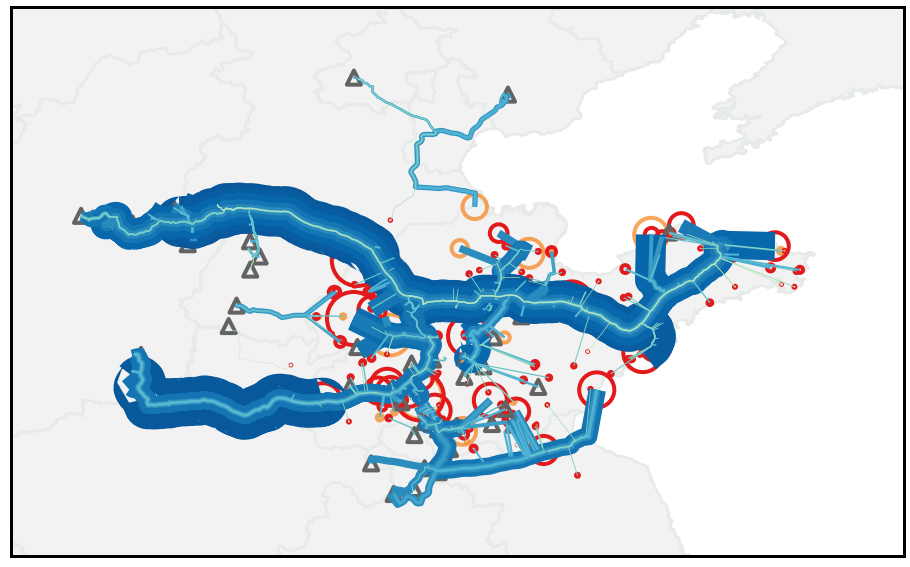

<IPython.core.display.Javascript object>

In [390]:
map_draw(transport_gdf_2010, power_plant_points_2010, color_dict=color_dict)

plt.savefig(
    r"E:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transport2010.png",
    dpi=600,
    bbox_inches="tight",
)

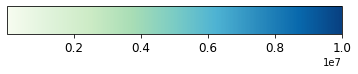

<IPython.core.display.Javascript object>

In [12]:
colorbar(transport_gdf_2010)

plt.savefig(
    r"E:\tencent files\chrome Download\Research\LCA\LCA Coal_fired power plant phaseout\Figures\transportcolor.png",
    dpi=600,
    bbox_inches="tight",
)

## Data manipulation

In [12]:
def read_gdf_file(transport_route_path, i):
    os.chdir(transport_route_path)
    gdf_file_list = os.listdir(transport_route_path)
    with open(gdf_file_list[i], "rb") as file:
        transport_gdf = pickle.load(file)
    return transport_gdf

<IPython.core.display.Javascript object>

In [13]:
def read_distance_matrix(transport_quantity_path):
    trans_mat = pd.read_excel(transport_quantity_path, index_col=0).T.stack()
    return trans_mat

<IPython.core.display.Javascript object>

In [14]:
def gdf_concat(transport_route_path, transport_quantity_path, i):
    transport_quantity_df = read_distance_matrix(transport_quantity_path)
    gdf_file_list = os.listdir(transport_route_path)
    transport_quan_pp = transport_quantity_df[int(gdf_file_list[i][:6])]
    transport_route_gdf = read_gdf_file(transport_route_path, i).set_index(
        transport_quan_pp.index
    )
    transport_df = pd.concat([transport_route_gdf, transport_quan_pp], axis=1)
    transport_df_route = transport_df[transport_df.iloc[:, -1] != 0]
    return transport_df_route

<IPython.core.display.Javascript object>

In [15]:
def gdf_total(transport_route_path, transport_quantity_path, pp_numbers):
    ls = []
    for i in range(pp_numbers):
        transport_df_route = gdf_concat(
            transport_route_path, transport_quantity_path, i
        )
        ls.append(transport_df_route)
    gdf_total = pd.concat(ls)
    gdf_total.crs = "epsg:32643"
    gdf_total = gdf_total.to_crs("epsg:4326")
    return gdf_total

<IPython.core.display.Javascript object>

In [16]:
len(os.listdir(transport_route_path_2014))

96

<IPython.core.display.Javascript object>

In [ ]:
%%time

transport_gdf_2010 = gdf_total(transport_route_path_2010, transport_quantity_path_2010, len(os.listdir(transport_route_path_2010)))
os.chdir(os.path.join(path, trans_2010))

with open("transport_route_gdf.pickle", "wb") as file:
    pickle.dump(transport_gdf_2010, file)

In [ ]:
transport_gdf_2014 = gdf_total(
    transport_route_path_2014,
    transport_quantity_path_2014,
    len(os.listdir(transport_route_path_2014)),
)

os.chdir(os.path.join(path, trans_2014))

with open("transport_route_gdf.pickle", "wb") as file:
    pickle.dump(transport_gdf_2014, file)